(linreg_stan)=

# Linear regression (Stan)

We will now conduct the same linear regression as in [the previous chapter](linreg_pymc), but with [Stan](https://mc-stan.org/) rather than PyMC. The Stan documentation has [an example of linear regression model](https://mc-stan.org/docs/2_27/stan-users-guide/linear-regression.html) as well.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
from cmdstanpy import CmdStanModel

## Data

The data file can be downloaded [here](https://github.com/srouchier/buildingenergygeeks/blob/master/data/linreg.csv).

Text(0.5, 0, 'classdays')

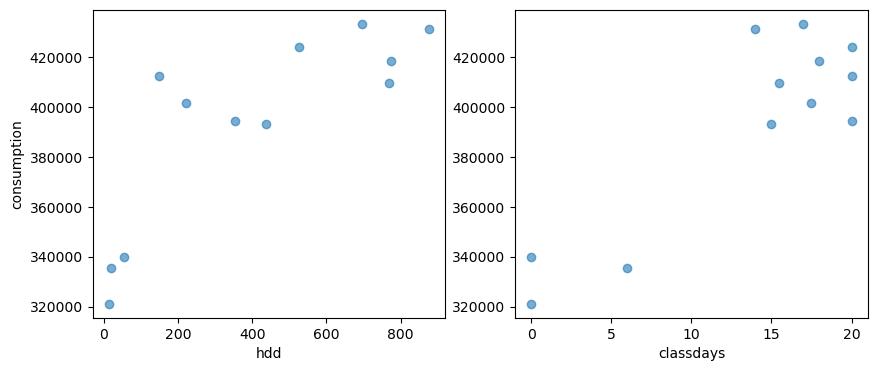

In [2]:
df = pd.read_csv('data/linreg.csv')
# Separating pre and post periods
df_train = df[df['period']=="pre"]
df_test = df[df['period']=="post"]

# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(df_train['HDD'], df_train['consumption'], alpha=0.6)
axes[1].scatter(df_train['CLASSDAYS'], df_train['consumption'], alpha=0.6)
axes[0].set_ylabel("consumption")
axes[0].set_xlabel("hdd")
axes[1].set_xlabel("classdays")

## Model specification

A Stan model is a block of text that can either be written in a separate file, or in the same script as the current code. Stan has high-level interfaces with most programming languages. Here, we'll use [CmdStanPy](https://mc-stan.org/cmdstanpy/index.html).

```{code} stan
data {
  int<lower=0> N;     // number of data items
  int<lower=0> K;     // number of predictors
  matrix[N, K] x;     // predictor matrix
  vector[N] y;        // outcome vector
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
 }
model {
  y ~ normal(x * beta + alpha, sigma);  // likelihood
}
generated quantities {
  array[N] real log_lik;
  array[N] real y_hat;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(y[j] | x[j] * beta + alpha, sigma);
    y_hat[j] = normal_rng(x[j] * beta + alpha, sigma);
  }
}
```

This code should has been written into a dedicated file called `linearregression.stan`, which can be downloaded [here](https://github.com/srouchier/buildingenergygeeks/blob/master/models/linearregression.stan).

In [3]:
model = CmdStanModel(stan_file='models/linearregression.stan')

If there is no compiled executable of this model in this filepath, this function will create one. If there is and the model has not been modified, it will load it without recompilation. This allows saving time when fitting the same model: compiling a new or modified model for the first time takes a while, but then the compiled executable is saved and the model may be re-used at will with different data sets.

## Training

The sample() method is used to do Bayesian inference over the model conditioned on data using using Hamiltonian Monte Carlo (HMC) sampling. It runs Stan’s HMC-NUTS sampler on the model and data and returns a CmdStanMCMC object. CmdStanPy allows specifying the data as a Python dictionary.

In the [PyMC linear regression example](linreg_pymc), we fit two models: one with only HDD as explanatory variable, and one with also the class days. Let us do the same here:

In [4]:
# Data declaration for model 1
model1_data = {
    "N": len(df_train),
    "K": 1,
    "x": df_train[['HDD']].values,
    "y": df_train['consumption'].values,
}

# Fitting model 1
fit1 = model.sample(data=model1_data, show_progress=False)

09:54:13 - cmdstanpy - INFO - CmdStan start processing
09:54:13 - cmdstanpy - INFO - Chain [1] start processing
09:54:13 - cmdstanpy - INFO - Chain [2] start processing
09:54:13 - cmdstanpy - INFO - Chain [3] start processing
09:54:13 - cmdstanpy - INFO - Chain [4] start processing


09:54:14 - cmdstanpy - INFO - Chain [3] done processing
09:54:15 - cmdstanpy - INFO - Chain [1] done processing
09:54:15 - cmdstanpy - INFO - Chain [4] done processing
09:54:16 - cmdstanpy - INFO - Chain [2] done processing


In [5]:
# Data declaration for model 2
model2_data = {
    "N": len(df_train),
    "K": 2,
    "x": df_train[['HDD', 'CLASSDAYS']].values,
    "y": df_train['consumption'].values,
}

# Fitting model 2
fit2 = model.sample(data=model2_data, show_progress=False)

09:54:16 - cmdstanpy - INFO - CmdStan start processing
09:54:16 - cmdstanpy - INFO - Chain [1] start processing
09:54:16 - cmdstanpy - INFO - Chain [2] start processing
09:54:16 - cmdstanpy - INFO - Chain [3] start processing
09:54:16 - cmdstanpy - INFO - Chain [4] start processing
09:54:18 - cmdstanpy - INFO - Chain [3] done processing
09:54:19 - cmdstanpy - INFO - Chain [4] done processing
09:54:19 - cmdstanpy - INFO - Chain [1] done processing
09:54:19 - cmdstanpy - INFO - Chain [2] done processing


We can see than sampling is quite fast once the model has been compiled.

*Note*: the `show_progress=False` argument used above is only to simplify the display on this page. It can be removed or set to True to track the progress of sampling.

[CmdStan has diagnostics utilities: stansummary and diagnose](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#cmdstan-utilities-stansummary-diagnose)

The `summary()` method runs an utility that reads the outputs of all chains and computes summary statistics for all sampler and model parameters and quantities of interest. It also returns summaries of the total joint log-probability density `lp__`. 

In [6]:
fs = fit1.summary(percentiles=(5, 50, 95))
fs.loc[['alpha', 'beta[1]', 'sigma', 'lp__']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,351957.0000,367.627000,13780.000000,329221.000,352384.0000,374190.000,1405.020000,730.259000,0.999853
beta[1],100.2520,0.697350,26.573900,57.367,99.9952,143.995,1452.140000,754.750000,0.999405
sigma,27345.6132,203.997122,7403.755025,18267.100,25965.8000,41039.000,1317.212973,684.622127,1.000971
lp__,-117.5860,0.044984,1.419820,-120.228,-117.2350,-116.031,996.235000,517.794000,1.002270


In [7]:
fs = fit2.summary(percentiles=(5, 50, 95))
fs.loc[['alpha', 'beta[1]', 'beta[2]', 'sigma', 'lp__']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,325605.00000,235.844000,9436.19000,310892.0000,325514.0000,340604.0000,1600.83000,1137.76000,1.004220
beta[1],56.48890,0.383132,17.16070,29.7856,56.5464,83.7613,2006.19000,1425.86000,0.999786
beta[2],3261.10000,17.712800,734.32600,2063.7100,3259.4900,4438.6500,1718.71000,1221.55000,1.002670
sigma,14078.61626,125.454950,4278.56431,9125.7000,13254.4000,21583.4000,1163.10931,826.65907,1.003890
lp__,-110.08700,0.062631,1.80114,-113.5180,-109.7060,-108.0380,827.02500,587.79300,1.006430


Additionally, the diagnose() method runs an utility which analyzes the per-draw sampler parameters across all chains looking for potential problems which indicate that the sample isn’t a representative sample from the posterior.

In [8]:
print(fit2.diagnose())

Processing csv files: /tmp/tmplq8zu57i/linearregressionk24hs4cb/linearregression-20250923095416_1.csv, /tmp/tmplq8zu57i/linearregressionk24hs4cb/linearregression-20250923095416_2.csv, /tmp/tmplq8zu57i/linearregressionk24hs4cb/linearregression-20250923095416_3.csv, /tmp/tmplq8zu57i/linearregressionk24hs4cb/linearregression-20250923095416_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## Extracting results

The `fit1` and `fit2` objects include methods to access the sampler outputs. They are listed on [CmdStanPy's documentation](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#accessing-the-results) but we can mention two of them:

* `draws_pd()`: returns a pandas.DataFrame over all columns in the Stan CSV file. The argument vars can be used to restrict this to one or more variables.
* `draws_xr()`: returns an xarray.Dataset which maps model variable names to their respective values.


In [9]:
res_pd = fit1.draws_pd()
res_xr = fit1.draws_xr()
res_pd.head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,y_hat[3],y_hat[4],y_hat[5],y_hat[6],y_hat[7],y_hat[8],y_hat[9],y_hat[10],y_hat[11],y_hat[12]
0,1.0,1.0,1.0,-118.238,0.971145,0.339103,3.0,7.0,0.0,118.663,...,373191.0,408420.0,449295.0,444354.0,519855.0,458727.0,473612.0,422564.0,345776.0,357898.0
1,1.0,2.0,2.0,-118.237,0.993430,0.339103,4.0,15.0,0.0,119.749,...,355499.0,364834.0,377669.0,427364.0,470069.0,417393.0,413354.0,397723.0,398708.0,354786.0
2,1.0,3.0,3.0,-117.646,0.985189,0.339103,3.0,7.0,0.0,118.872,...,337474.0,403931.0,393499.0,427051.0,424879.0,438156.0,407038.0,403268.0,361106.0,359410.0
3,1.0,4.0,4.0,-118.426,0.659121,0.339103,3.0,7.0,0.0,119.950,...,364002.0,395530.0,387969.0,494433.0,485013.0,462230.0,418238.0,418811.0,447337.0,341333.0
4,1.0,5.0,5.0,-122.657,0.941061,0.339103,3.0,15.0,0.0,123.148,...,479027.0,311505.0,310124.0,368594.0,493771.0,488210.0,505653.0,423499.0,392101.0,304690.0



The ArviZ package for exploratory analysis of Bayesian models [can be used with CmdStanPy](https://python.arviz.org/en/stable/getting_started/Introduction.html#cmdstanpy-integration). To make the most out of ArviZ, it is recommended to convert the results to InferenceData. Doing so improves the `res_xr` xarray by assigning all variables to the right groups.

In [10]:
idata1 = az.from_cmdstanpy(
    posterior = fit1,
    posterior_predictive="y_hat",
    observed_data={"y": df_train['consumption'].values},
    constant_data={"x": df_train[['HDD']].values},
    log_likelihood="log_lik",
    dims={
        "y_hat": ["observations"],
        "log_lik": ["observations"],
        "y": ["observations"],
        "beta": ["features"]
        },
)

idata2 = az.from_cmdstanpy(
    posterior = fit2,
    posterior_predictive="y_hat",
    observed_data={"y": df_train['consumption'].values},
    constant_data={"x": df_train[['HDD', 'CLASSDAYS']].values},
    log_likelihood="log_lik",
    dims={
        "y_hat": ["observations"],
        "log_lik": ["observations"],
        "y": ["observations"],
        "beta": ["features"]
        },
)

idata2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

We can now use the same posterior plots as we did with the PyMC output:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

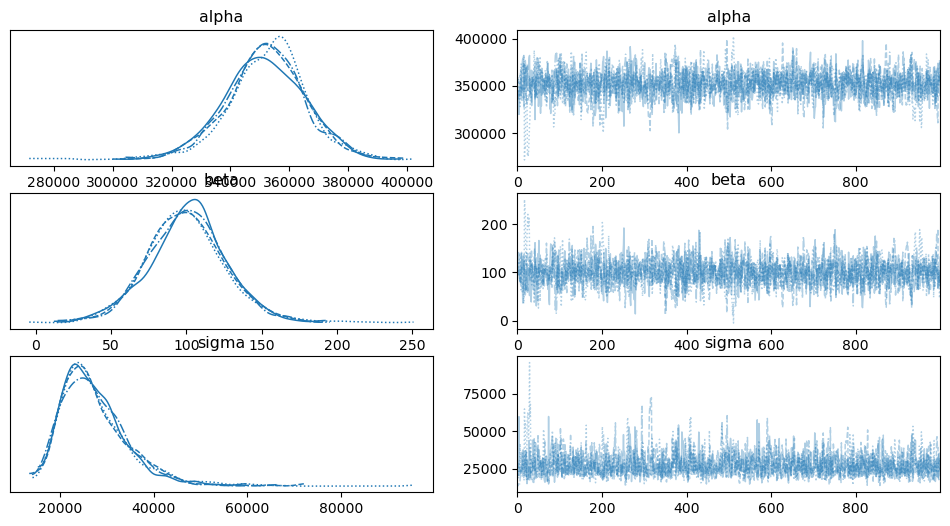

In [11]:
az.plot_trace(idata1)

And here is the posterior predictive distribution:

Text(0.5, 0, 'class days')

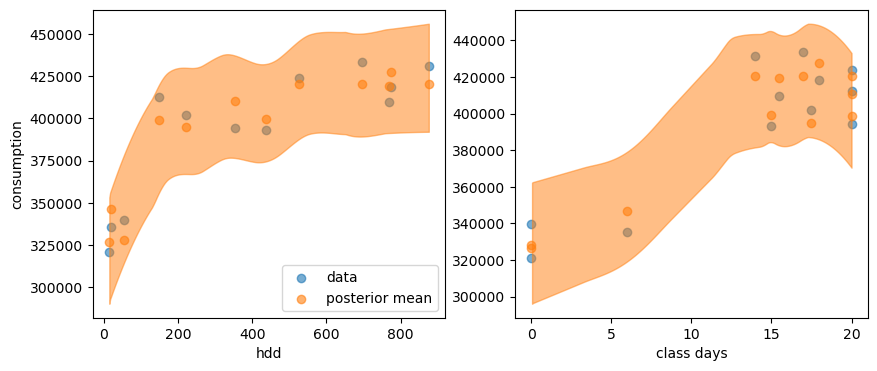

In [12]:
y_post = idata2.posterior_predictive["y_hat"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(df_train['HDD'], df_train['consumption'], alpha=0.6, label='data')
axes[0].scatter(df_train['HDD'], y_post.mean(("chain", "draw")), c="C1", alpha=0.6, label='posterior mean')
az.plot_hdi(df_train['HDD'], y_post, ax=axes[0])
axes[0].set_xlabel("hdd")
axes[0].set_ylabel("consumption")
axes[0].legend()

axes[1].scatter(df_train['CLASSDAYS'], df_train['consumption'], alpha=0.6)
axes[1].scatter(df_train['CLASSDAYS'], y_post.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(df_train['CLASSDAYS'], y_post, ax=axes[1])
axes[1].set_xlabel("class days")

Reassuringly, this looks exactly like the posterior distribution we had from PyMC.

## Model comparison metrics

The built-in LOO method of ArviZ can be used now (see the [previous chapter](linreg_pymc) for a reminder of what is happening here):

In [13]:
df_comp_loo = az.compare({"model1": idata1, "model2": idata2}, ic="loo")
df_comp_loo

/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model2,0,-132.533091,3.046308,0.000000,1.0,1.155242,0.000000,True,log
model1,1,-140.311554,2.490824,7.778464,0.0,2.074431,2.016874,False,log
